In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, GRU, add, Concatenate, Reshape, concatenate
from tensorflow.keras.applications import ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

warnings.filterwarnings('ignore')

2024-04-27 14:16:06.182017: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-27 14:16:06.182104: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-27 14:16:06.316520: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Import Flickr8k-Images-Captions data

In [2]:
data_location = "/kaggle/input/flickr8kimagescaptions/flickr8k"

In [3]:
df=pd.read_csv(data_location+"/captions.txt")

df.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [4]:
df.shape

(40455, 2)

In [5]:
indices = 7000

sample_df = df.drop_duplicates(subset='image')
sample_df.head(10)

image  \
0   1000268201_693b08cb0e.jpg   
5   1001773457_577c3a7d70.jpg   
10  1002674143_1b742ab4b8.jpg   
15  1003163366_44323f5815.jpg   
20  1007129816_e794419615.jpg   
25  1007320043_627395c3d8.jpg   
30  1009434119_febe49276a.jpg   
35  1012212859_01547e3f17.jpg   
40  1015118661_980735411b.jpg   
45  1015584366_dfcec3c85a.jpg   

                                              caption  
0   A child in a pink dress is climbing up a set o...  
5          A black dog and a spotted dog are fighting  
10  A little girl covered in paint sits in front o...  
15  A man lays on a bench while his dog sits by him .  
20     A man in an orange hat starring at something .  
25                    A child playing on a rope net .  
30  A black and white dog is running in a grassy g...  
35  A dog shakes its head near the shore , a red b...  
40  A boy smiles in front of a stony wall in a city .  
45                     A black dog leaps over a log .

In [6]:
del df
sample_df.shape

(8091, 2)

## Show some images


In [7]:
def preProcessImage(imagepath,img_size=224):
    img = load_img(imagepath,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = preProcessImage(f"{data_location}/images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

In [8]:
# def displayImage(image):
#     image=preProcessImage(f"{data_location}/images/{image}")
#     plt.imshow(image)

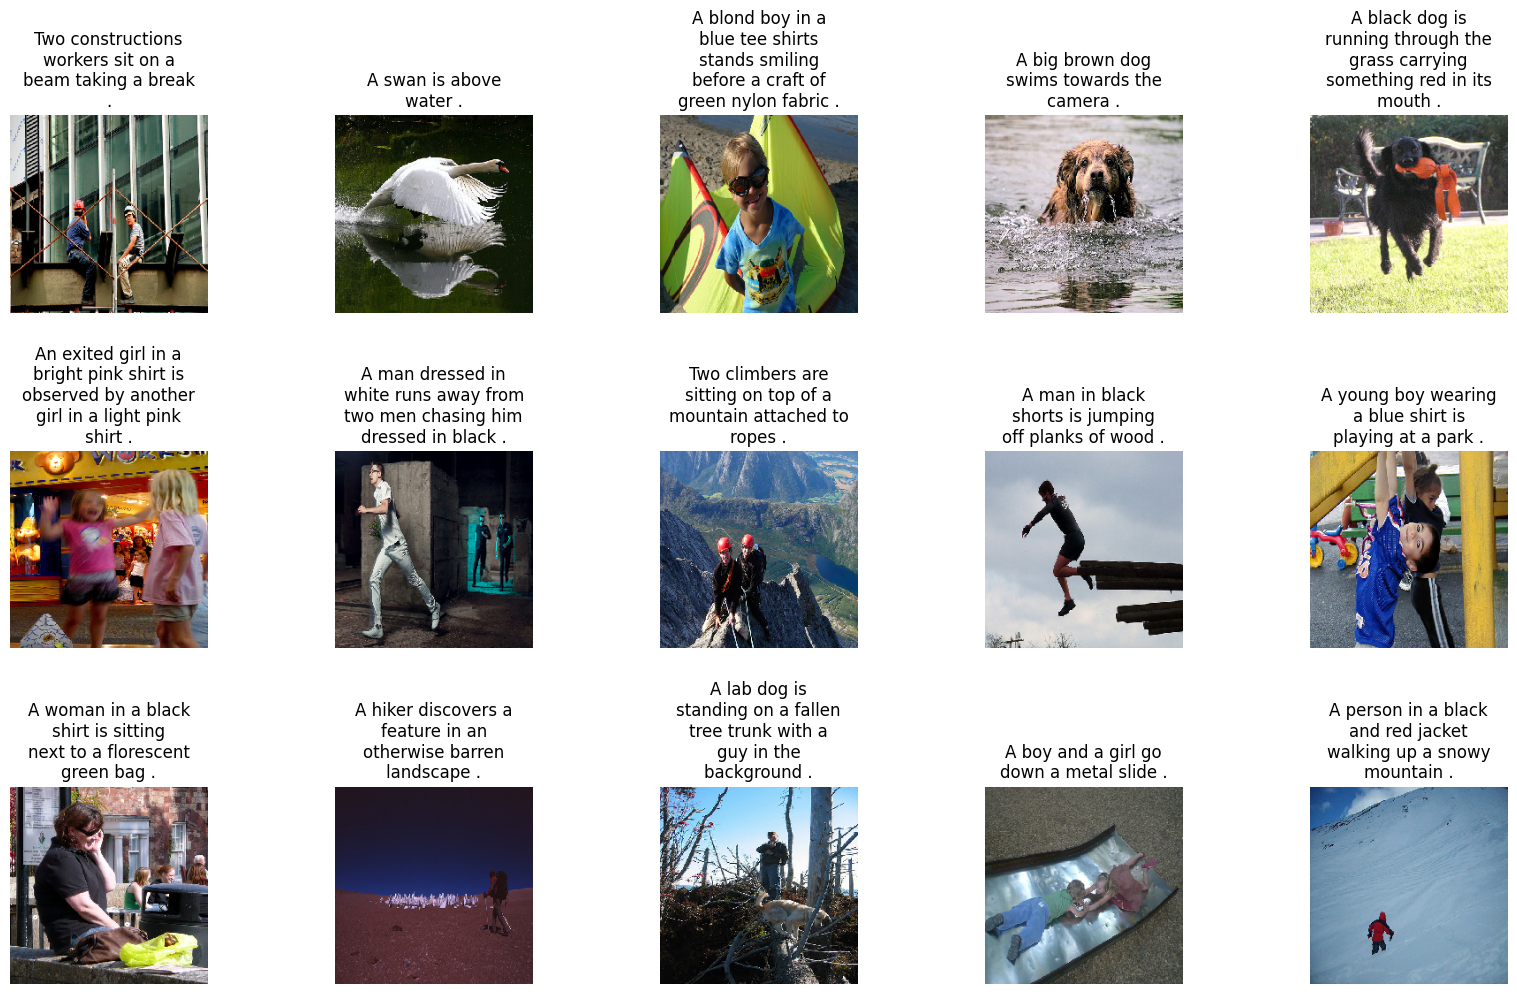

In [9]:
display_images(sample_df.sample(15))

## Text Preprocessing

In [8]:
import nltk
from nltk.tokenize import word_tokenize

def clean_text(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower()) # convert to lower case
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]","")) # keep only the alphabetic
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," ")) # remove extra spaces
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1])) # remove single character
    
    data['caption'] = data['caption'].apply(lambda x: word_tokenize(x))
    data['caption'] = data['caption'].apply(lambda x: ['<start>'] + x + ['<end>'])
    
    return data
clean_text(sample_df)

sample_df.head()

image  \
0   1000268201_693b08cb0e.jpg   
5   1001773457_577c3a7d70.jpg   
10  1002674143_1b742ab4b8.jpg   
15  1003163366_44323f5815.jpg   
20  1007129816_e794419615.jpg   

                                              caption  
0   [<start>, child, in, pink, dress, is, climbing...  
5   [<start>, black, dog, and, spotted, dog, are, ...  
10  [<start>, little, girl, covered, in, paint, si...  
15  [<start>, man, lays, on, bench, while, his, do...  
20  [<start>, man, in, an, orange, hat, starring, ...

# Split the data



In [9]:
nimages=sample_df.shape[0]

split_index = round(0.85*nimages)

train_data = sample_df[:split_index]
test_data = sample_df[split_index:]

# Extract features from images using ResNet Model

In [10]:
ResNet_model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [11]:
images_vectors = []

unique_images= np.unique(np.array(train_data['image']))
for image_name in unique_images:
    
    img = preProcessImage(f"{data_location}/images/{image_name}") 
    image_array = np.expand_dims(img, axis=0)
    pred = ResNet_model.predict(image_array,verbose=0).reshape(2048)
    images_vectors.append(pred)

I0000 00:00:1714227493.659046     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [12]:
arr=np.array(images_vectors)
np.save('imagevectors_file.npy', arr)
arr.shape

(6877, 2048)

In [13]:
words = []
words = [word for caption in train_data['caption'] for word in caption]

In [14]:
len(words)

77112

In [15]:
# Creating a list of all unique words
unique = []
for i in words:
    unique.append(i)
unique = list(set(unique))

print(len(unique))

4190


In [16]:
word_2_indices = {val:index for index, val in enumerate(unique)}
indices_2_word = {index:val for index, val in enumerate(unique)}

In [17]:
print(len(indices_2_word.keys()))
print(len(word_2_indices.keys()))


4190
4190


In [18]:
indexTomodify=len(indices_2_word.keys())
wordtoSwitch=indices_2_word [0]

In [19]:
word_2_indices['<pad>'] = 0
indices_2_word [0] = '<pad>'

word_2_indices[wordtoSwitch] = indexTomodify
indices_2_word[indexTomodify] = wordtoSwitch

In [20]:
print(len(word_2_indices.keys()))
print(len(indices_2_word.keys()))

4191
4191


In [21]:
vocab_size = len(word_2_indices.keys())
print(vocab_size)

4191


In [30]:
word_2_indices['<end>']

2339

In [22]:
MAX_LEN_CAPTION = 0
for i in  train_data['caption']:
    if MAX_LEN_CAPTION < len(i):
        MAX_LEN_CAPTION =len(i)

MAX_LEN_CAPTION 

30

In [23]:
train_data.shape

(6877, 2)

In [24]:
train_data.head()

image  \
0   1000268201_693b08cb0e.jpg   
5   1001773457_577c3a7d70.jpg   
10  1002674143_1b742ab4b8.jpg   
15  1003163366_44323f5815.jpg   
20  1007129816_e794419615.jpg   

                                              caption  
0   [<start>, child, in, pink, dress, is, climbing...  
5   [<start>, black, dog, and, spotted, dog, are, ...  
10  [<start>, little, girl, covered, in, paint, si...  
15  [<start>, man, lays, on, bench, while, his, do...  
20  [<start>, man, in, an, orange, hat, starring, ...

##  Padding
#### - each sentence will be -> ( "Start" A girl going into a wooden building "END" PAD PAD PAD...) 
#### - and its corresponding vector -> [  3649, 504, 141, 486,  31, 503, 374,  21, 505, 388, 2339,   0,   0,   0...]
### Generate sequence for each caption (sequencesData)
####  - for each sentence iteratively keep some words and hide the next word 
####  - because of the decoder will work like a language model (learn to predict the next word )


In [25]:
def getSequences(uniqueImages,imageFeatures,df,maxLen):
    processedDF = pd.DataFrame(columns=['imagex', 'textx', 'Y'])
    for index, row in df.iterrows():
        rowoft=row['caption']
        rowofi=row['image']
        featureindex=np.where(uniqueImages == rowofi)[0][0]
        imgfeature=imageFeatures[featureindex]
#         originalList=[]
        
        for i in range (len(rowoft)):
            partList=rowoft[:i+1]+['<pad>']*(maxLen-i-1)
            y=rowoft[i+1]
            newRow={'imagex':[imgfeature],'textx':[partList],'Y':[y]}
            newrowdf=pd.DataFrame(newRow)
            processedDF = pd.concat([processedDF, newrowdf], ignore_index=True)
            if y =='<end>':
                break
        if index%1000==0:
            print (index)
    return processedDF
        

In [26]:
sequencesData=getSequences(unique_images,arr,train_data,MAX_LEN_CAPTION)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000


In [27]:
sequencesData.head()

imagex  \
0  [0.0, 0.0, 0.0073847114, 0.0, 1.4741292, 0.0, ...   
1  [0.0, 0.0, 0.0073847114, 0.0, 1.4741292, 0.0, ...   
2  [0.0, 0.0, 0.0073847114, 0.0, 1.4741292, 0.0, ...   
3  [0.0, 0.0, 0.0073847114, 0.0, 1.4741292, 0.0, ...   
4  [0.0, 0.0, 0.0073847114, 0.0, 1.4741292, 0.0, ...   

                                               textx      Y  
0  [<start>, <pad>, <pad>, <pad>, <pad>, <pad>, <...  child  
1  [<start>, child, <pad>, <pad>, <pad>, <pad>, <...     in  
2  [<start>, child, in, <pad>, <pad>, <pad>, <pad...   pink  
3  [<start>, child, in, pink, <pad>, <pad>, <pad>...  dress  
4  [<start>, child, in, pink, dress, <pad>, <pad>...     is

## Vectorization
#### - Use word_2_indices dictionary that have all unique words in Captions where id = sorted_index & key = unique_word 
#### - map sequencesData tokenizedData 
#### - (word -> index)

In [34]:
def tokenizeword(word):
    return word_2_indices.get(word,None)

def tokenizelist(listofWord):
    return [word_2_indices.get(word,None)for word in listofWord]

def paddingAndVectorizing(sequencesData):
    sequenceData=sequencesData.copy()
    sequenceData['tokenizedtext']=sequenceData['textx'].apply(tokenizelist)
    sequenceData['tokenizedY']=sequenceData['Y'].apply(tokenizeword)
    sequenceData.drop(['textx', 'Y'], axis=1,inplace=True)
    return sequenceData

In [ ]:
# def ChangetoWord2vec(word):
#     return get_embedding_vector(word)
# def detokenize(listoFtokens):
#     return [indices_2_word.get(word,None)for word in listoFtokens]
# def paddingAndVectorizingEmbeddings(sequencesData):
#     sequenceData=sequencesData.copy()
#     sequenceData['tokenizedtext']=sequenceData['textx'].apply(tokenizelist)
#     sequenceData['tokenizedY']=sequenceData['Y'].apply(ChangetoWord2vec)
#     sequenceData.drop(['textx', 'Y'], axis=1,inplace=True)
#     return sequenceData

# word2VectokenizedData=paddingAndVectorizingEmbeddings(sequencesData)

In [39]:
tokenizedData=paddingAndVectorizing(sequencesData)
tokenizedData.head()

imagex  \
0  [0.0, 0.0, 0.0073847114, 0.0, 1.4741292, 0.0, ...   
1  [0.0, 0.0, 0.0073847114, 0.0, 1.4741292, 0.0, ...   
2  [0.0, 0.0, 0.0073847114, 0.0, 1.4741292, 0.0, ...   
3  [0.0, 0.0, 0.0073847114, 0.0, 1.4741292, 0.0, ...   
4  [0.0, 0.0, 0.0073847114, 0.0, 1.4741292, 0.0, ...   

                                       tokenizedtext  tokenizedY  
0  [3649, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...        1327  
1  [3649, 1327, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...        3724  
2  [3649, 1327, 3724, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...        2147  
3  [3649, 1327, 3724, 2147, 0, 0, 0, 0, 0, 0, 0, ...        3163  
4  [3649, 1327, 3724, 2147, 3163, 0, 0, 0, 0, 0, ...        1811

In [36]:
textx=tokenizedData['tokenizedtext'].tolist()
textx=np.array(textx)
imagex=tokenizedData['imagex'].tolist()
imagex=np.array(imagex)
trainY=tokenizedData['tokenizedY'].tolist()
trainY=np.array(trainY)
print(textx.shape)
print(imagex.shape)
print(trainY.shape)

(70235, 30)
(70235, 2048)
(70235,)


# Encoder

In [240]:
from keras.layers import Masking

# imageFeatures=Input((2048,),name='imginput')
encInput=Input((30,),name='encoder_input')
mask = Masking(mask_value=0,name ='mask')(encInput)
embedding = Embedding(vocab_size, 256,name='encoder_embedding')(mask)

grUnit1=GRU(256,return_sequences=True,name='encoderGru2')(embedding)
grUnit=GRU(256,name='encoderGru3')(grUnit1)

encoder=Model(inputs=encInput,outputs=grUnit)
encoder.summary()

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mask (Masking)                  │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_embedding (Embedding)   │ (None, 30, 256)        │     1,072,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoderGru2 (GRU)               │ (None, 30, 256)        │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoderGru3 (GRU)               │ (None, 256)            │       394,752 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,862,400 (7.10 MB)

 Trainable params: 1,862,400 (7.10 MB)

 Non-trainable params: 0 (0.00 B)

# Decoder

In [241]:
decImgInput=Input((256,),name='decImgInput')
dexTexInput=Input((256,),name='decTexInput')
concatenated=Concatenate()([decImgInput,dexTexInput])
dense1=Dense(2048,activation='relu',name='decFirstDense')(concatenated)
droplayer=Dropout(0.3,name='imgdropoutdec')(dense1)
dense1=Dense(1024,activation='relu',name='decsecondDense')(droplayer)
softClassifier=Dense(vocab_size,activation='softmax',name='decSoftmax')(dense1)
decoder=Model(inputs=[decImgInput,dexTexInput],outputs=softClassifier)
print(decoder.summary())

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ decImgInput         │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decTexInput         │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 512)       │          0 │ decImgInput[0][0… │
│ (Concatenate)       │                   │            │ decTexInput[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decFirstDense       │ (None, 2048)      │  1,050,624 │ concatenate_3[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ imgdropoutdec       │ (None, 2048)      │          0 │ decFirstDense[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decsecondDense      │ (None, 1024)      │  2,098,176 │ imgdropoutdec[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decSoftmax (Dense)  │ (None, 4191)      │  4,295,775 │ decsecondDense[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,444,575 (28.40 MB)

 Trainable params: 7,444,575 (28.40 MB)

 Non-trainable params: 0 (0.00 B)

None


# Image to Sequence Model

In [76]:
WholeModel.summary()
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
WholeModel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
WholeModel.fit([imagex,textx],trainY,epochs=200,batch_size=512,callbacks=[early_stopping])

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ imginput            │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_input       │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_13       │ (None, 256)       │  2,360,576 │ imginput[0][0]    │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_15       │ (None, 256)       │  1,862,400 │ encoder_input[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_17       │ (None, 4191)      │  7,444,575 │ functional_13[0]… │
│ (Functional)        │                   │            │ functional_15[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 35,002,655 (133.52 MB)

 Trainable params: 11,667,551 (44.51 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 23,335,104 (89.02 MB)

Epoch 1/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.7870 - loss: 0.7352
Epoch 2/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.7857 - loss: 0.7235
Epoch 3/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.7727 - loss: 0.7728
Epoch 4/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.7868 - loss: 0.7196
Epoch 5/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.7915 - loss: 0.7030
Epoch 6/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.7886 - loss: 0.7113
Epoch 7/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.7948 - loss: 0.6981
Epoch 8/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.8004 - loss: 0.6672
Epoch 9/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.8023 - loss: 0.6630
Epoch 10/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.7932 - loss: 0.6932
Epoch 11/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.7985 - loss: 0.6809
Epoch 12/200
138/138 ━━━━━━━━

In [52]:
def get_encoding(model, path):
    image = preProcessImage(path)
    image_array = np.expand_dims(image, axis=0)
    pred = ResNet_model.predict(image_array,verbose=0).reshape(2048)
    return pred
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word_2_indices[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=MAX_LEN_CAPTION, padding='post')
        preds = WholeModel.predict([np.array([image]), np.array(par_caps)],verbose=0)
        word_pred = indices_2_word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > MAX_LEN_CAPTION:
            break
            
    return ' '.join(start_word[1:-1])

In [136]:
from nltk.translate.bleu_score import corpus_bleu
from keras.preprocessing import image, sequence

predtestcaptions = []
paths=[]
i=0
for image_path in test_data['image']:
    if i ==100:
        break
    i=i+1
    path=f"{data_location}/images/{image_path}"
    test_img = get_encoding(ResNet_model,path )
    predCaption = predict_captions(test_img)
    paths.append(path)
    predtestcaptions.append(predCaption.split())

In [137]:
references = []
i=0
for _, row in test_data.iterrows():
    
    listtoappedn=row['caption'].copy()
    listtoappedn.remove('<start>')
    listtoappedn.remove('<end>')
    references.append([listtoappedn])
    i=i+1
    if i==100:
        break

bleu_score = corpus_bleu(references, predtestcaptions)

print("BLEU Score:", bleu_score)

BLEU Score: 0.1661918437016625


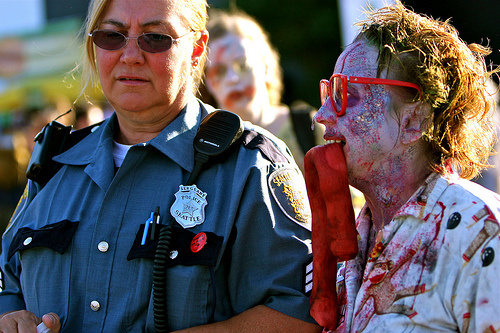

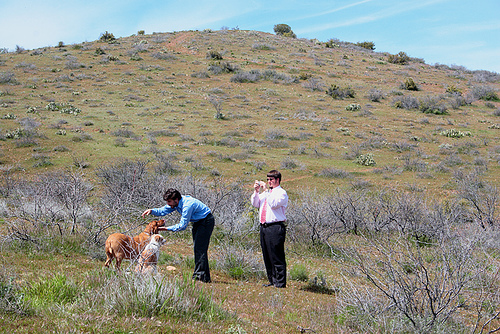

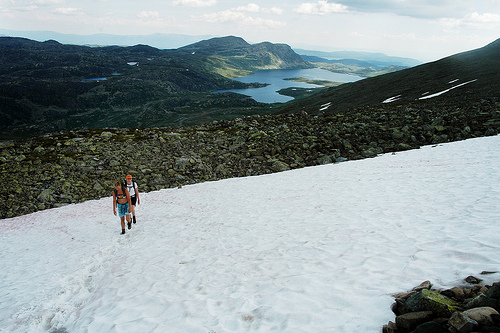

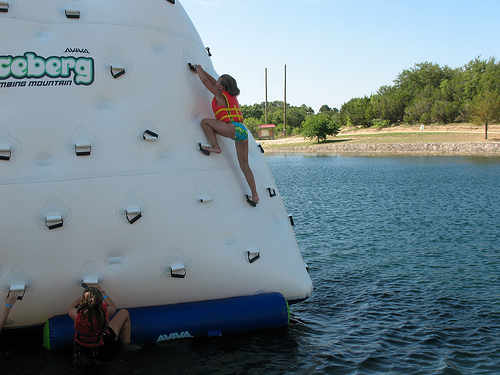

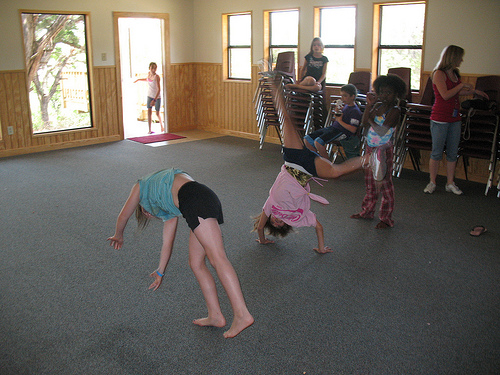

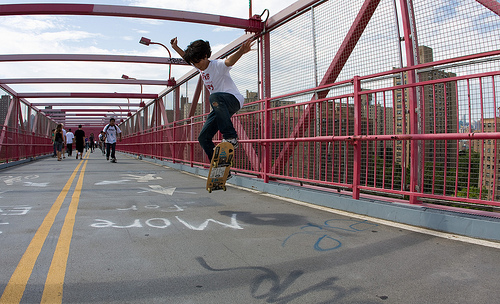

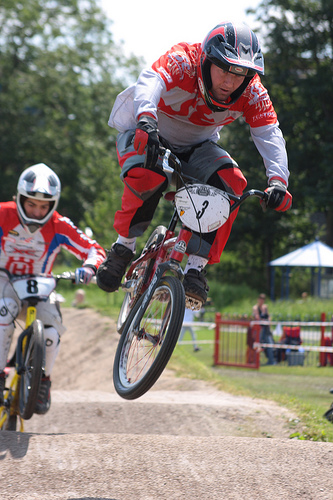

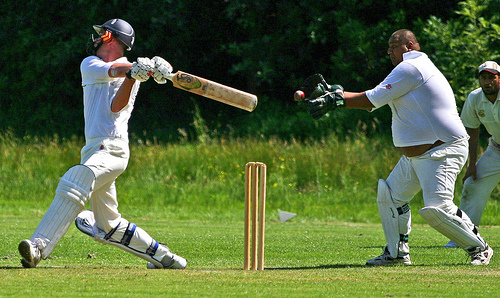

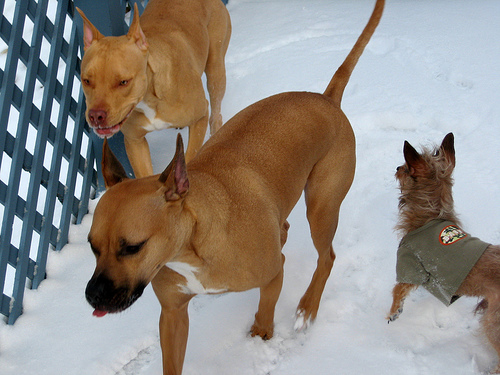

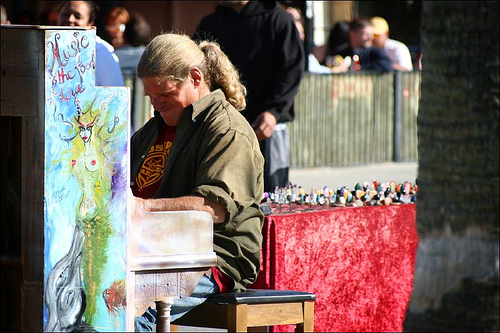

In [57]:
from IPython.display import Image, display,HTML
import html
for predicted_caption, actual_caption,path  in zip(predtestcaptions[10:20], references[10:20],paths[10:20]):

    z = Image(filename=path,)
    display(z)
    # Print the actual and predicted captions
    html_content = f'<div style="font-size: larger"><b>Actual Caption:</b> {actual_caption}</div>' \
                   f'<div style="font-size: larger"><b>Predicted Caption:</b> {predicted_caption}</div>'
    display(HTML(html_content))

In [226]:
image_path1 = "/kaggle/input/test-images3/test_images2/FB_IMG_1573579962493.jpg"
image_path2='/kaggle/input/test-images3/test_images2/Screenshot (966).png'
image_path3='/kaggle/input/test-images3/test_images2/FB_IMG_1623372604204.jpg'
image_path4='/kaggle/input/test-images3/test_images2/FB_IMG_1573579962493.jpg'
image_path5='/kaggle/input/test-images3/test_images2/FB_IMG_1681772015348.jpg'
image_path6='/kaggle/input/test-images3/test_images2/WhatsApp Image 2024-04-25 at 19.54.06_af618cb3.jpg'

def generate_caption(image_path):
    
    test_img = get_encoding(ResNet_model,image_path )
    Argmax_Search = predict_captions(test_img)
    z = Image(filename=image_path,width=750,height=750)
    display(z)
    print(Argmax_Search)

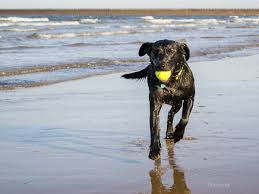

black dog shakes itself dry on the beach in front of the waves


In [211]:
generate_caption(image_path1)

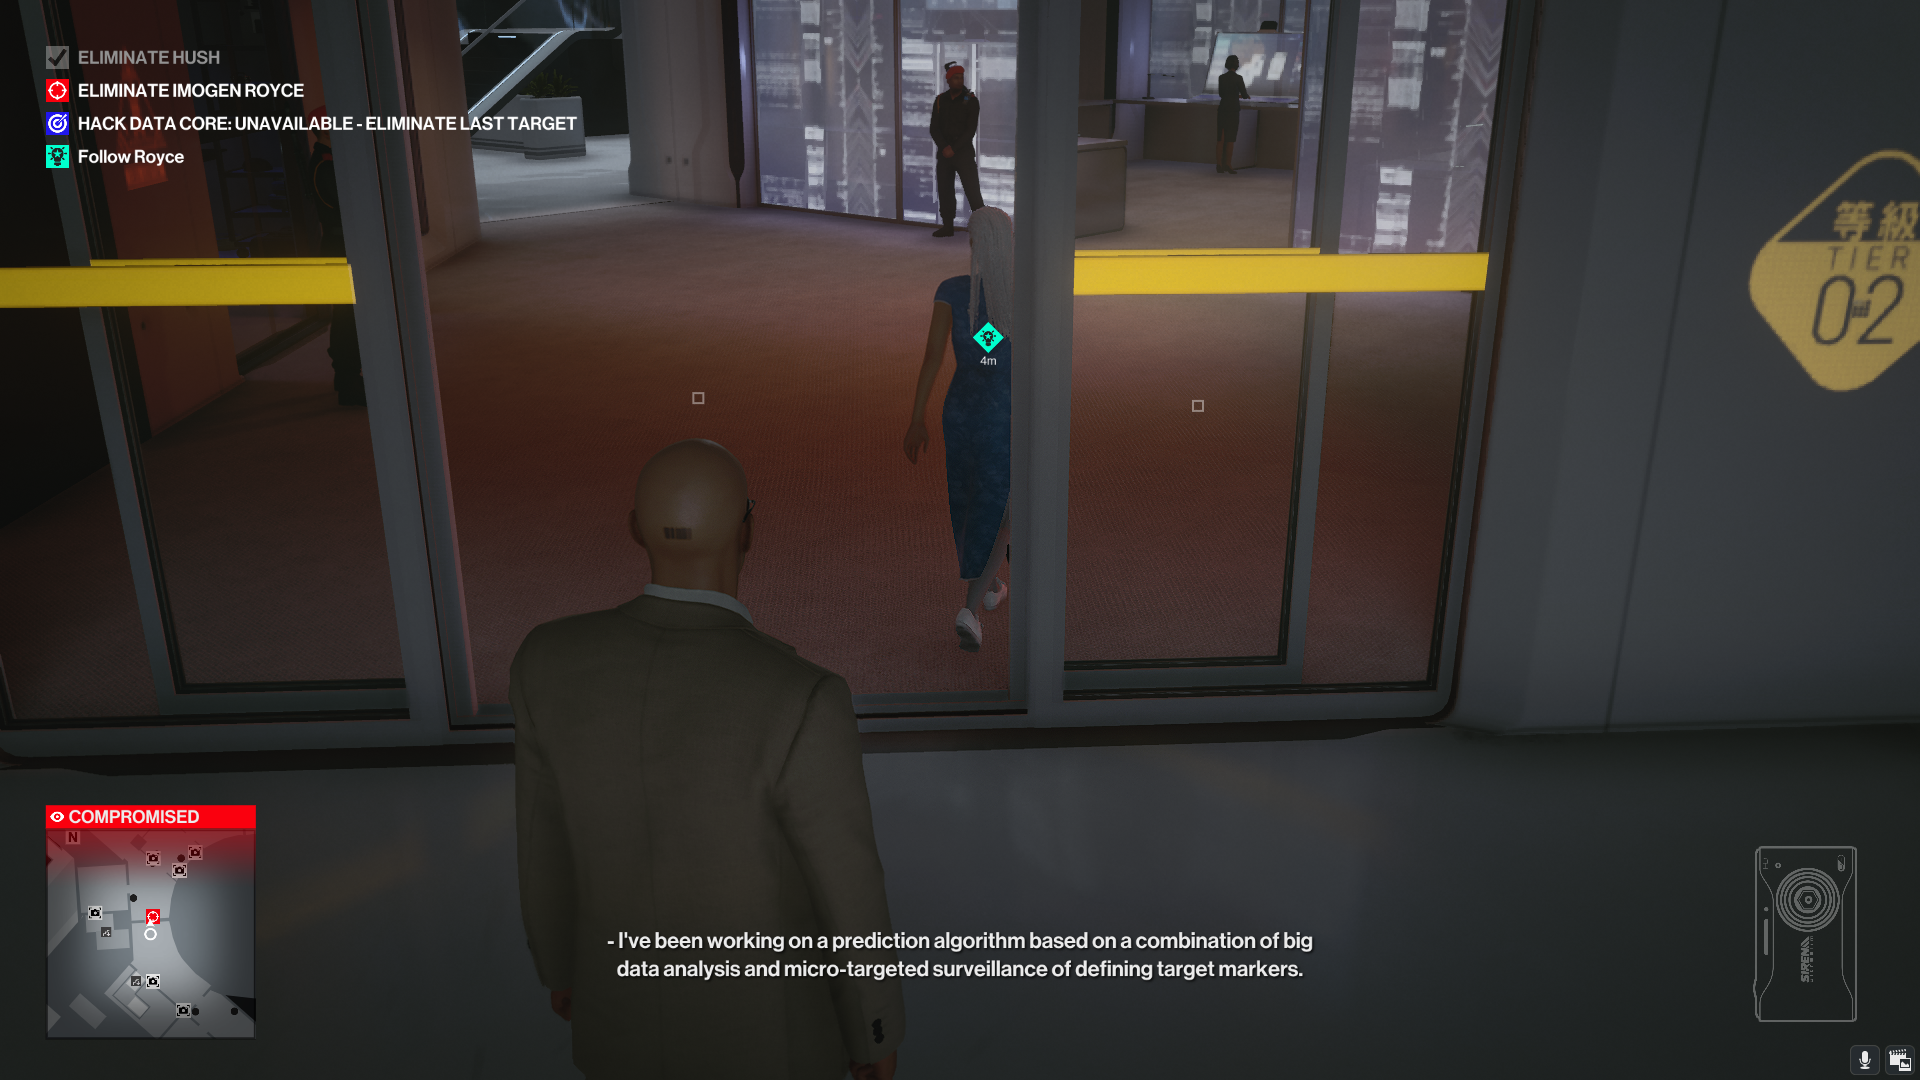

men one walking and one sitting balanced on shaft


In [227]:
generate_caption(image_path2)

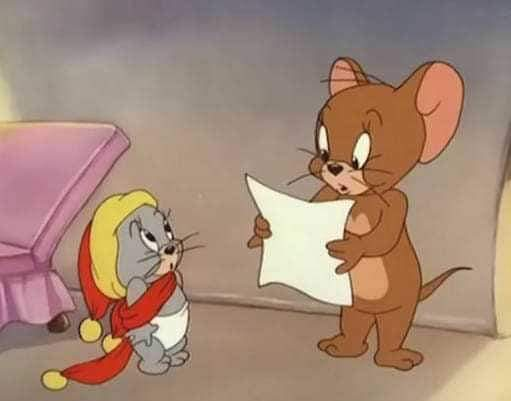

man in yellow helmet climbs up rock cliff


In [228]:
generate_caption(image_path3)

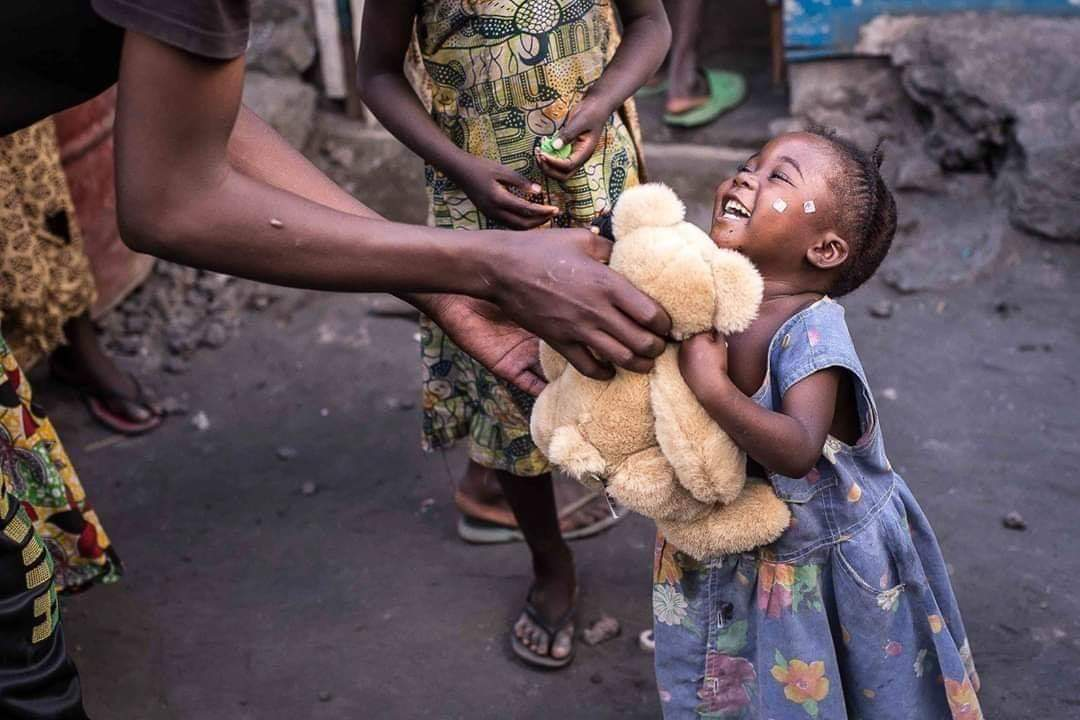

group of people wear black tophats


In [229]:
generate_caption(image_path4)

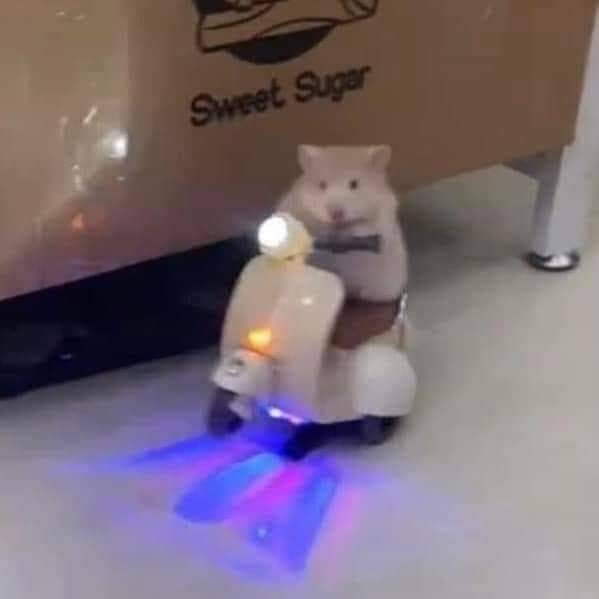

brown dog is laying on his side on beige carpet with green object in its mouth


In [231]:
generate_caption(image_path5)

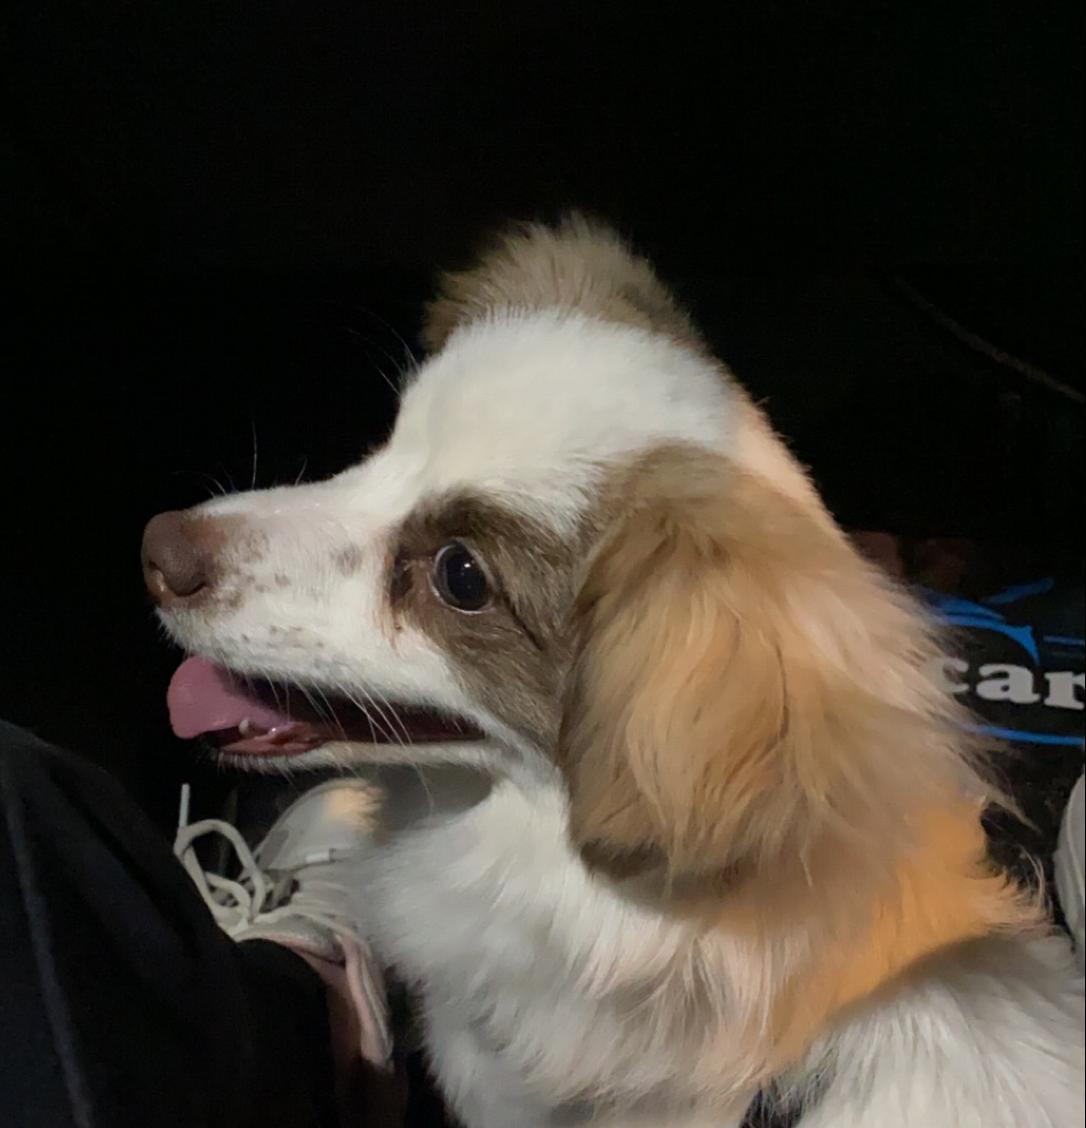

brown dog swims and carries brown object


In [232]:
generate_caption(image_path6)

# draft

In [ ]:
imageFeatures=Input((2048,),name='imginput')
x=Dense(1024,activation='relu',name="imgfirstDense")(imageFeatures)
# x=Dense(1024,activation='relu',name="imgsecondDense")(x)
droplayer=Dropout(0.3,name='imgdropout')(x)

dense2=Dense(256,activation='relu',name="imgthirdDense")(droplayer)
FEmodel2=Model(inputs=imageFeatures,outputs=dense2)
print(FEmodel.summary())
from keras.layers import Masking
encInput=Input((30,),name='encoder_input')
mask = Masking(mask_value=0,name ='mask')(encInput)
embedding = Embedding(vocab_size, 256,name='encoder_embedding')(mask)
# embedding = Masking(mask_value=0)(embedding)
# grUnit1=GRU(1024,return_sequences=True,name='encoderGru1')(embedding)
grUnit1=GRU(256,return_sequences=True,name='encoderGru2')(embedding)
grUnit=GRU(256,name='encoderGru3')(grUnit1)

encoder2=Model(inputs=encInput,outputs=grUnit)

print(encoder.summary())
decImgInput=Input((256,),name='decImgInput')
dexTexInput=Input((256,),name='decTexInput')
concatenated=Concatenate()([decImgInput,dexTexInput])
dense1=Dense(2048,activation='relu',name='decFirstDense')(concatenated)
droplayer=Dropout(0.3,name='imgdropoutdec')(dense1)
dense1=Dense(1024,activation='relu',name='decsecondDense')(droplayer)
softClassifier=Dense(trainY2.shape[1],activation='linear',name='declastembedding')(dense1)
decoder2=Model(inputs=[decImgInput,dexTexInput],outputs=softClassifier)
print(decoder.summary())


In [ ]:
WholeModel.summary()
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
WholeModel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
WholeModel.fit([imagex,textx],trainY,epochs=200,batch_size=2048,callbacks=[early_stopping])